In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thesis.io import fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate
from thesis.glitch import GlitchModel, GlitchPrior, estimate_asy

import thesis.jaxdaw as jd

import jax
import jax.numpy as jnp
from jax import random
jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import kernels, GaussianProcess

rng = random.PRNGKey(0)

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
data = fgong.load_fgong(filename)
data

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


In [75]:
name = "worst"
df = pd.read_csv(f"data/glitch-inputs-{name}.csv")
df.head()

,n,l,nu_true,nu,nu_err
0,18,0,2574.262983,2577.249488,1.0
1,19,0,2706.595870,2706.442841,1.0
2,20,0,2839.476225,2838.996750,1.0
3,21,0,2972.726600,2971.452099,1.0
4,22,0,3105.759219,3107.406018,1.0


In [76]:
n, nu, nu_err = df.n.to_numpy(), df.nu.to_numpy(), df.nu_err.to_numpy()

delta_nu, epsilon = estimate_asy(n, nu, nu_err=nu_err)
prior = GlitchPrior(delta_nu, epsilon)
model = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

print(f"{delta_nu.mean:.2f} ± {delta_nu.variance**0.5:.2f}")

132.83 ± 0.47


In [77]:
rng, key = random.split(rng)
prior_samples = prior.sample(key, shape=(1000,))

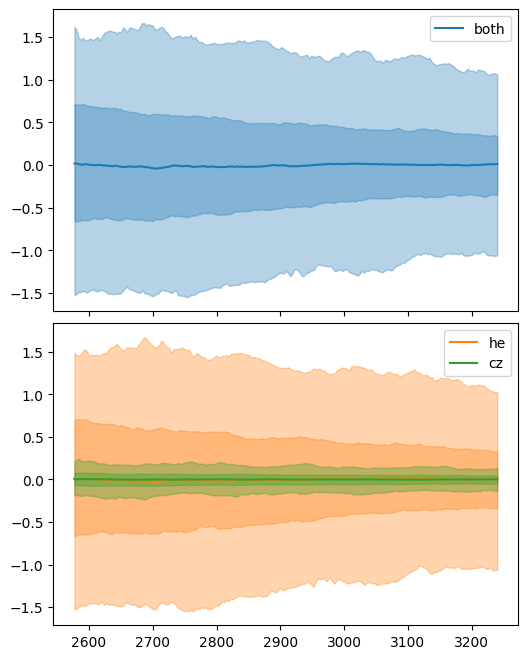

In [78]:
intervals = [(.16, .84), (.025, .975)]

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.04})
ax0 = model.plot_glitch(prior_samples, intervals=intervals, ax=axes[0])
ax0.legend()

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(prior_samples, kind=kind, intervals=intervals, color=f"C{i+1}", ax=ax1)
ax1.legend();

(-5.0, 5.0)

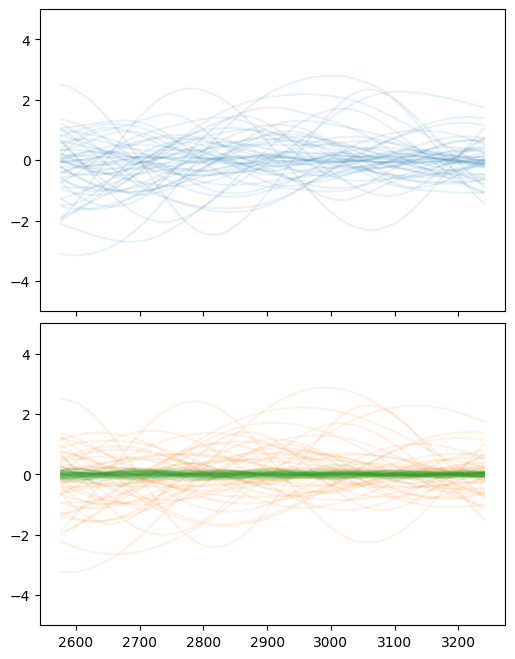

In [79]:
draws = 50
alpha = 0.1

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, sharey=True, gridspec_kw={"hspace": 0.04})
ax0 = model.plot_glitch(prior_samples, draws=draws, alpha=alpha, ax=axes[0])

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(prior_samples, kind=kind, draws=draws, alpha=alpha, color=f"C{i+1}", ax=ax1)

ax1.set_ylim(-5, 5)

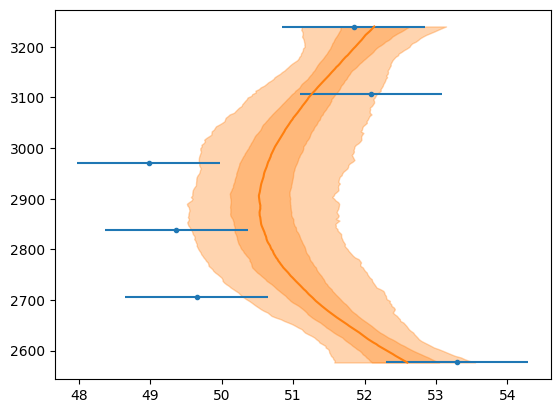

In [80]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, prior_samples, intervals=[(.16, .84), (.025, .975)])

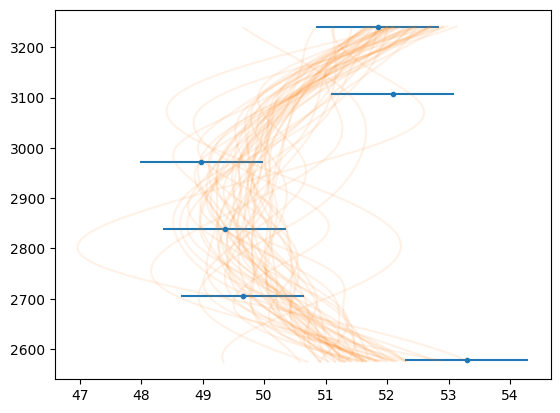

In [81]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, prior_samples, draws=50, alpha=0.1)

In [82]:
rstate = np.random.default_rng(0)
sampler = jd.NestedSampler(model, nlive=500, sample="rwalk", walks=50, rstate=rstate)

In [83]:
results = sampler.run_nested()

2153it [00:08, 268.78it/s, +500 | bound: 5 | nc: 1 | ncall: 36773 | eff(%):  7.314 | loglstar:   -inf < -11.466 <    inf | logz: -15.137 +/-  0.081 | dlogz:  0.001 >  0.509]


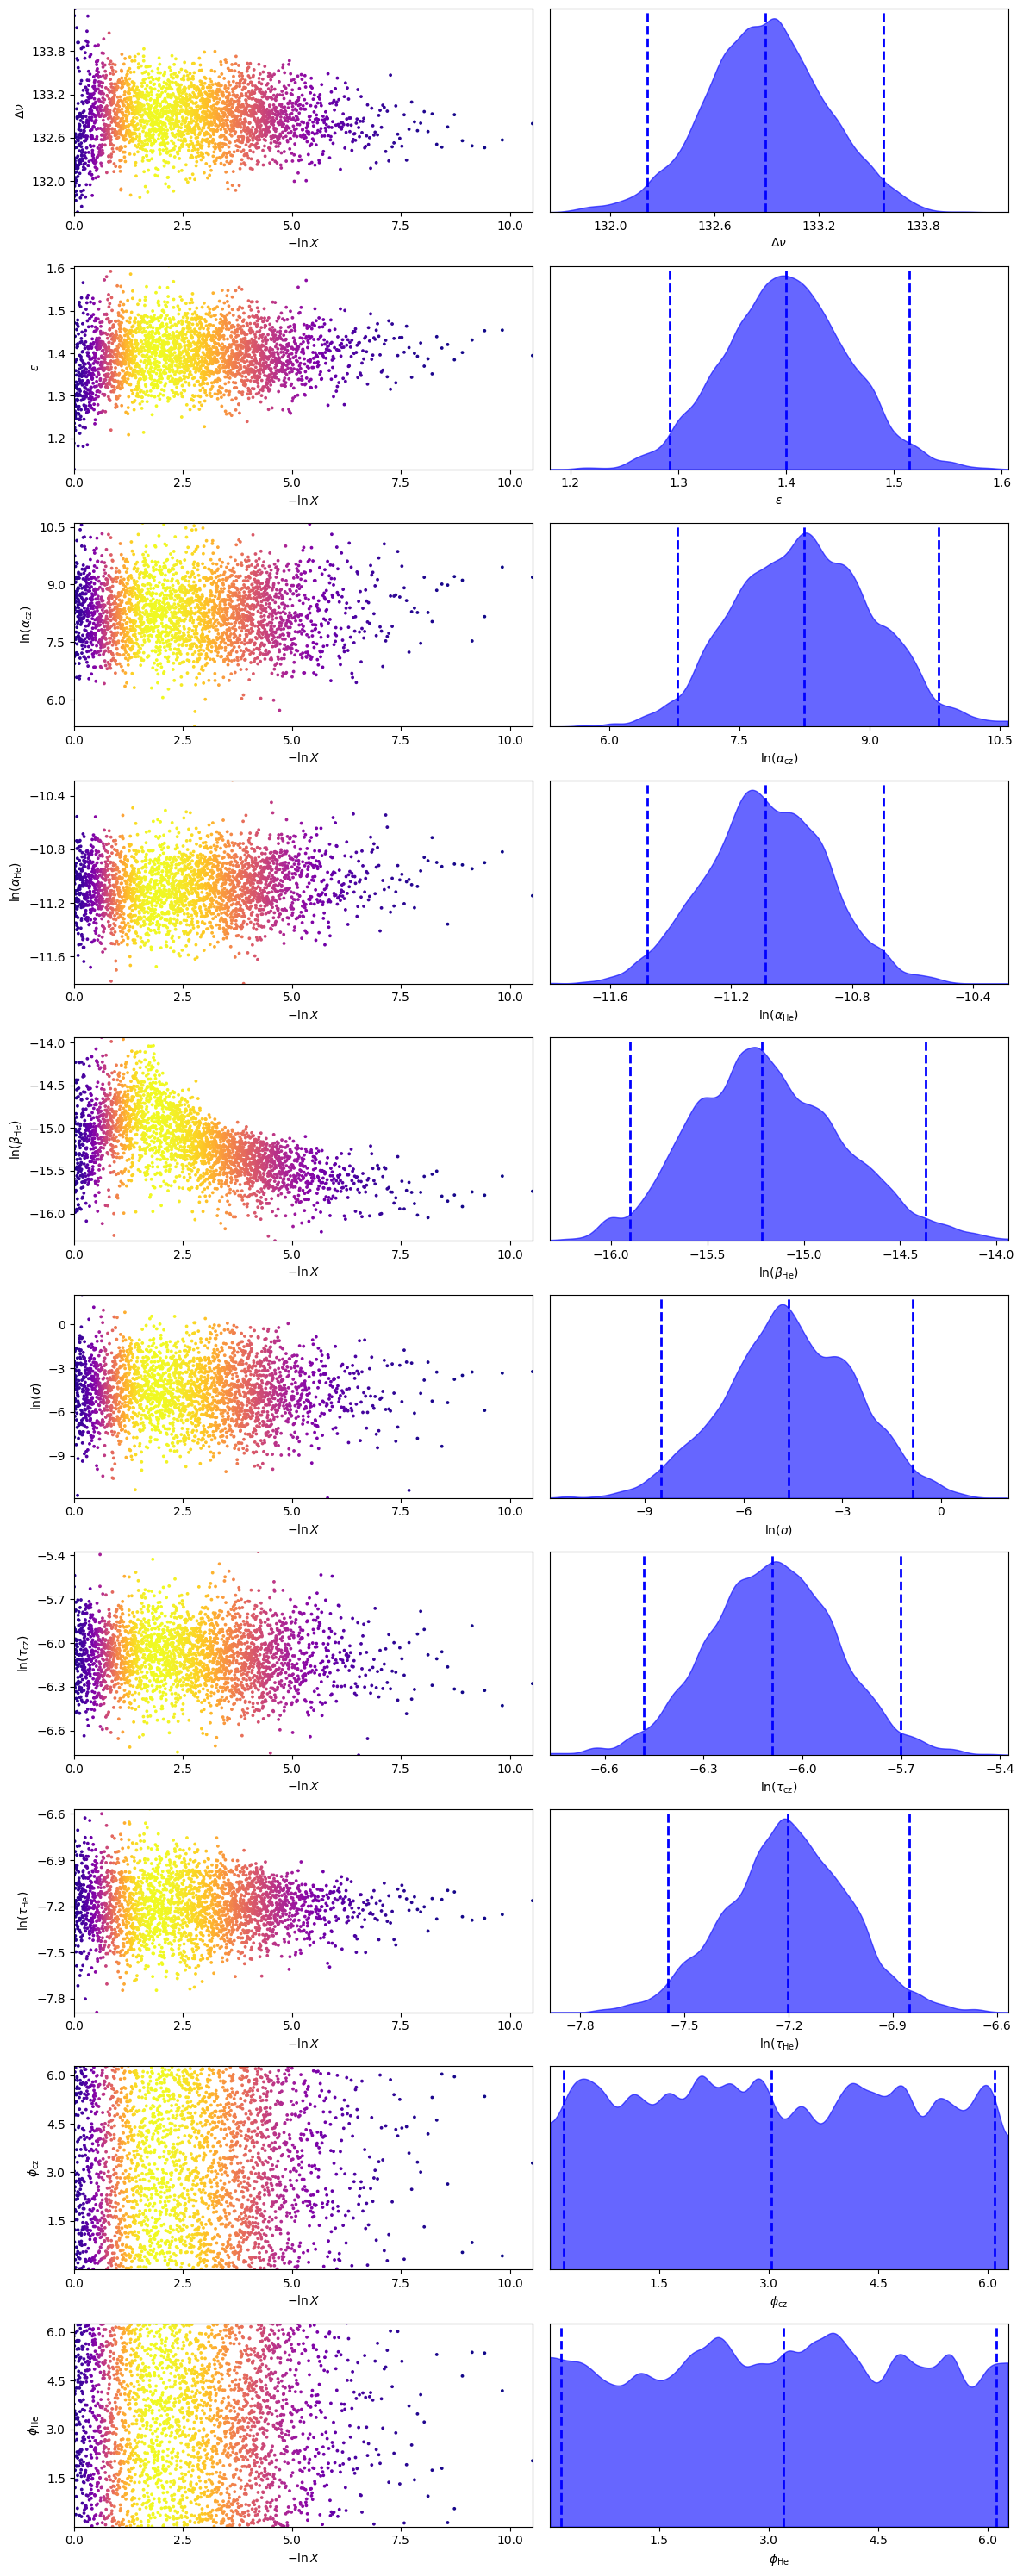

In [84]:
fig, axes = jd.traceplot(results, labels=model.symbols)
fig.tight_layout()

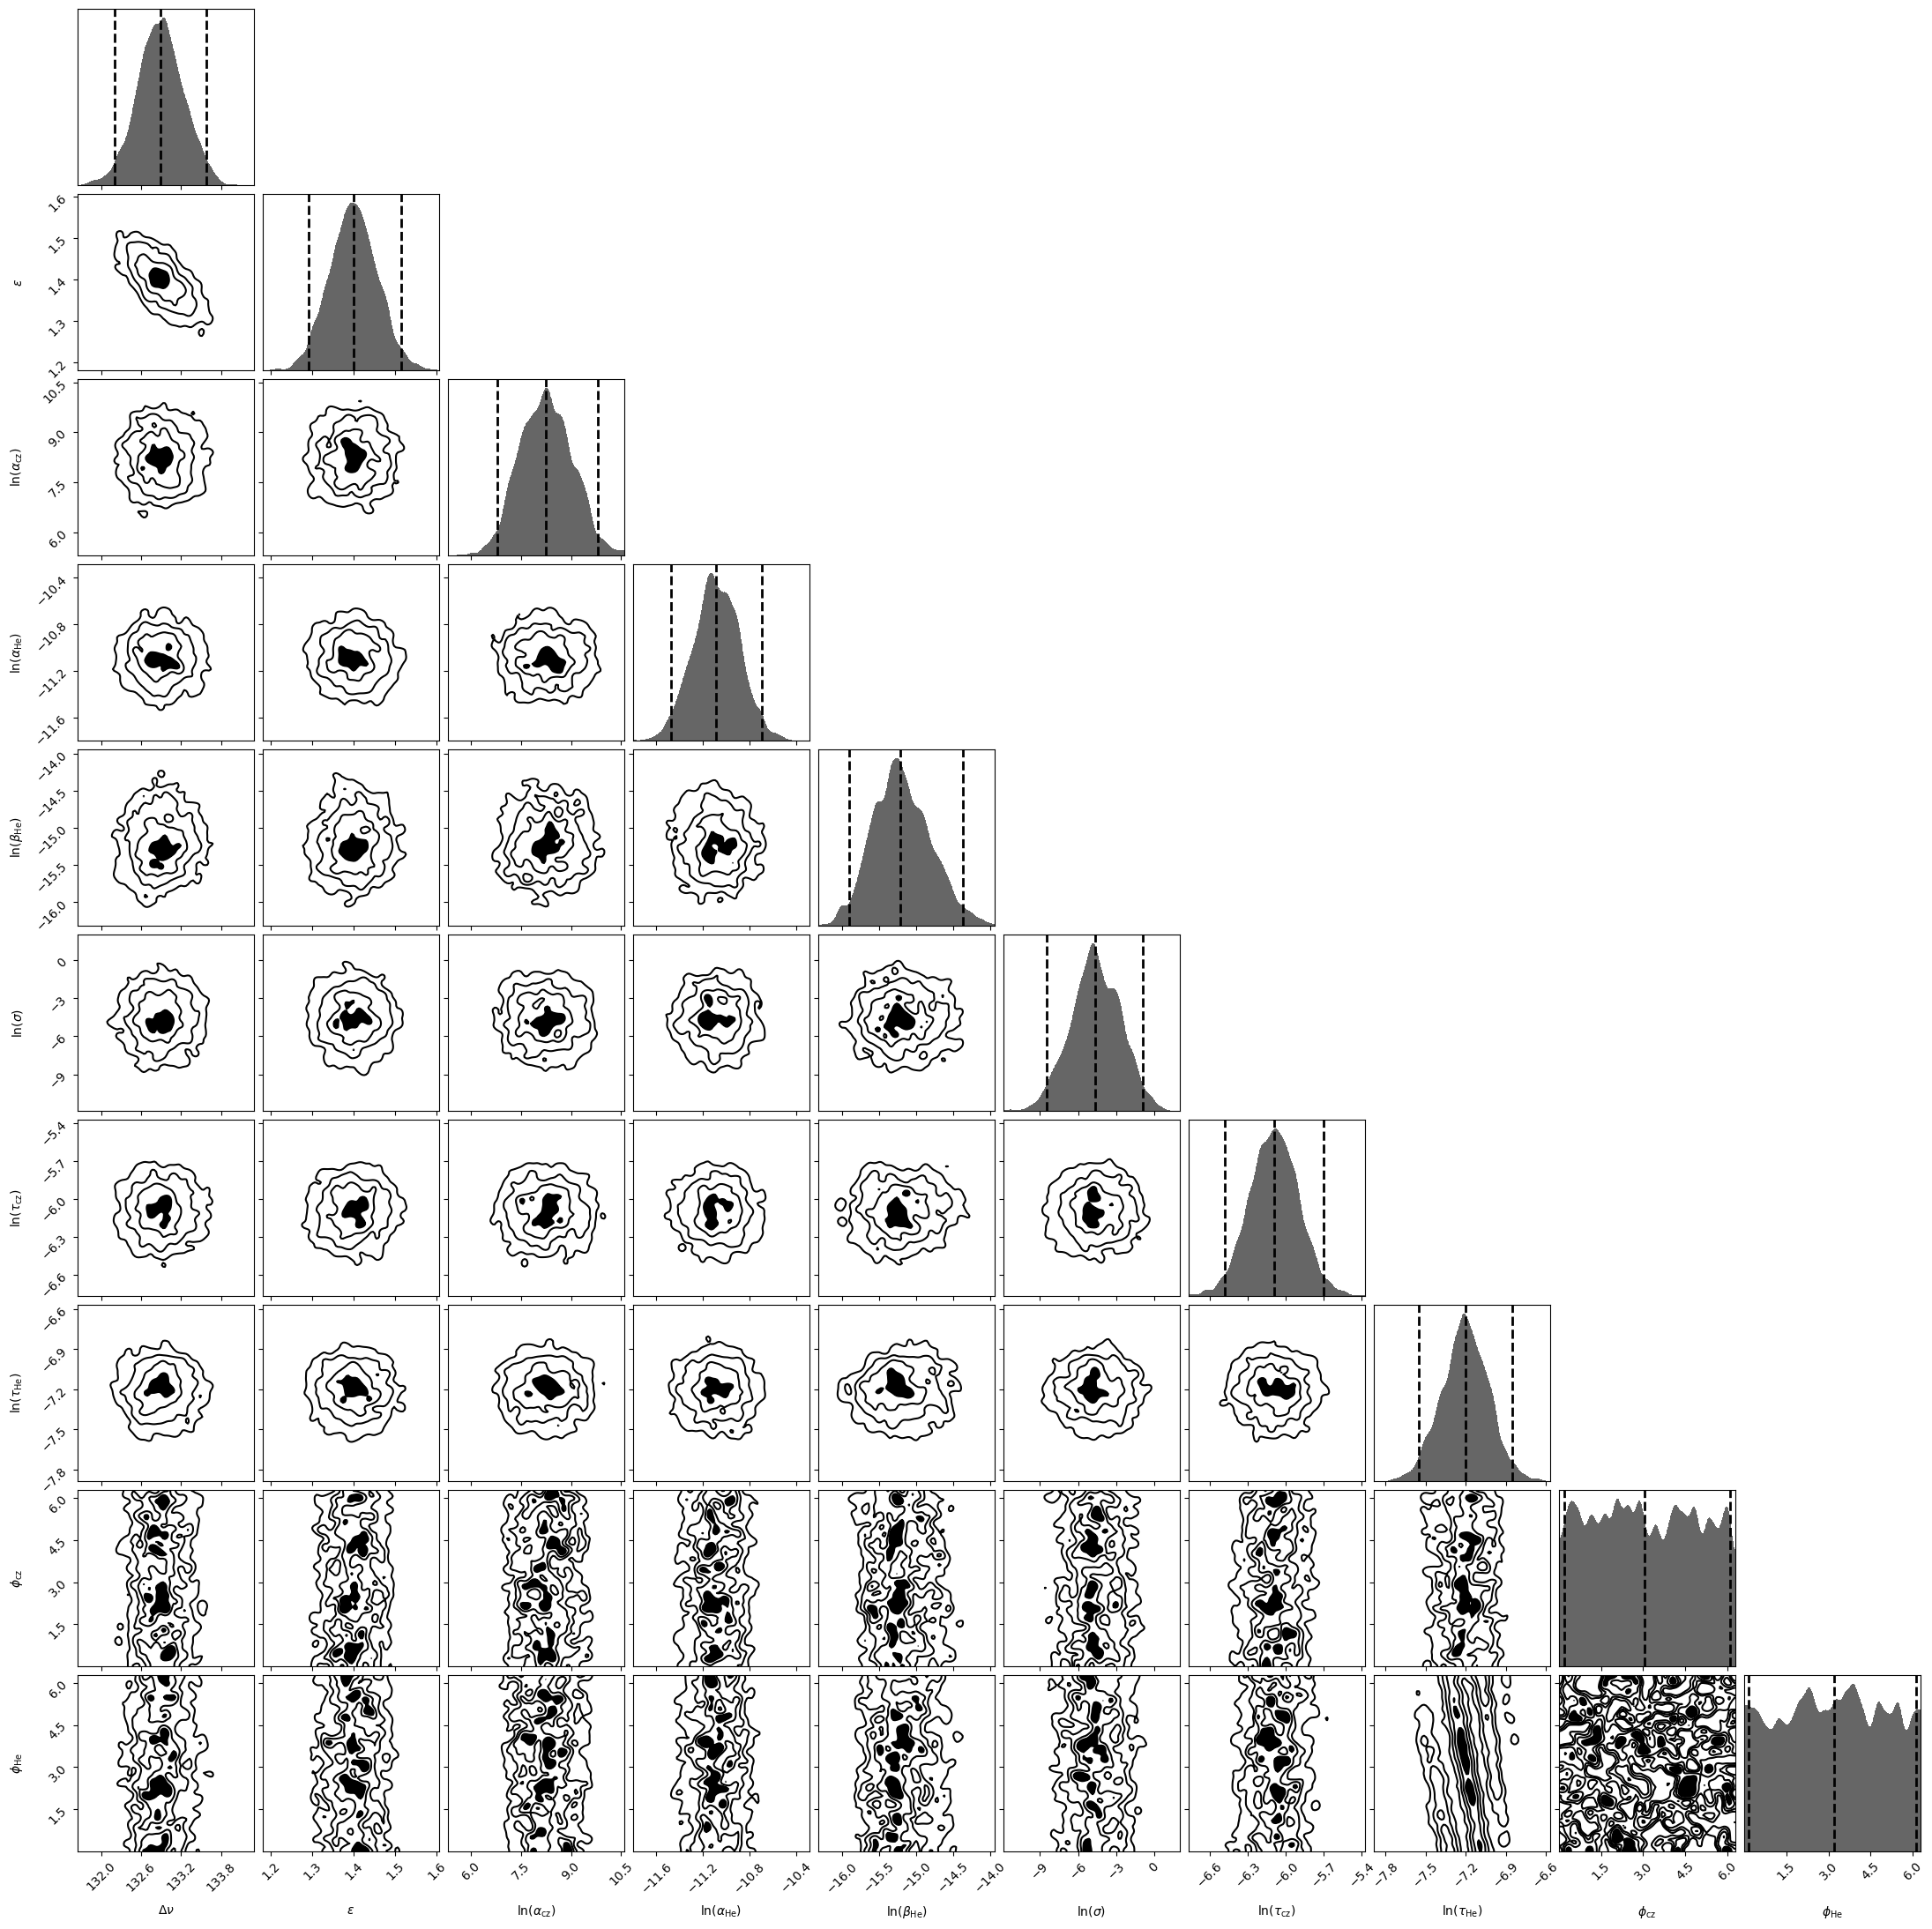

In [85]:
fig, ax = jd.cornerplot(results, labels=model.symbols)

In [86]:
filepath = f"data/gp-glitch-results-{name}.h5"
jd.save_results(results, filepath)

In [87]:
shape = (1000,)
rng, key = random.split(key)

samples = jd.resample(key, results, shape=shape)

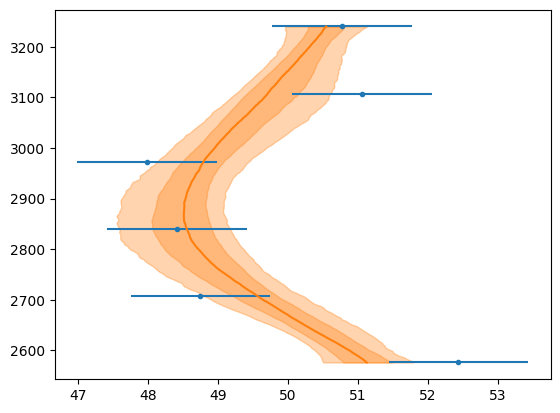

In [88]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples, intervals=[(.16, .84), (.025, .975)])

In [89]:
nu_max_sol = 3090.0
g_sol = 10**4.44
teff_sol = 5777.0

g = data.G * data.M / data.R**2
nu_max = nu_max_sol * g / g_sol * (data.Teff/teff_sol)**-0.5

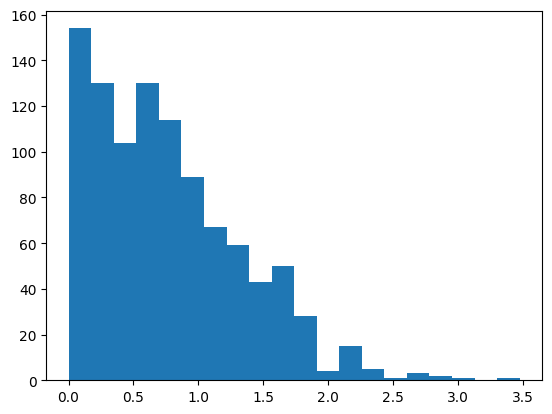

In [90]:
fig, ax = plt.subplots()
ax.hist(model.helium_amp(samples, nu_max), bins=20);

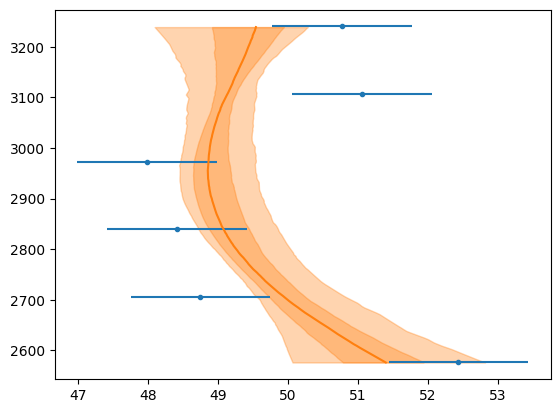

In [91]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples, kind="gp", intervals=[(.16, .84), (.025, .975)])

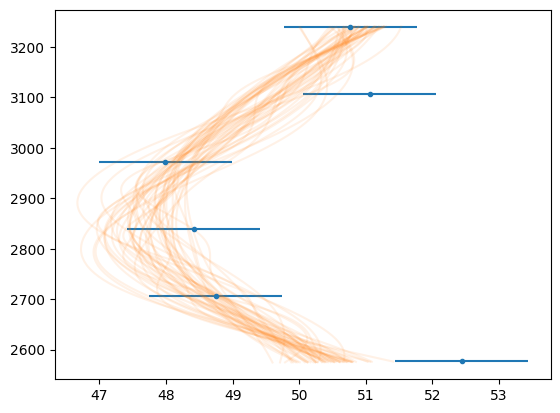

In [92]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples, draws=50, alpha=0.1)

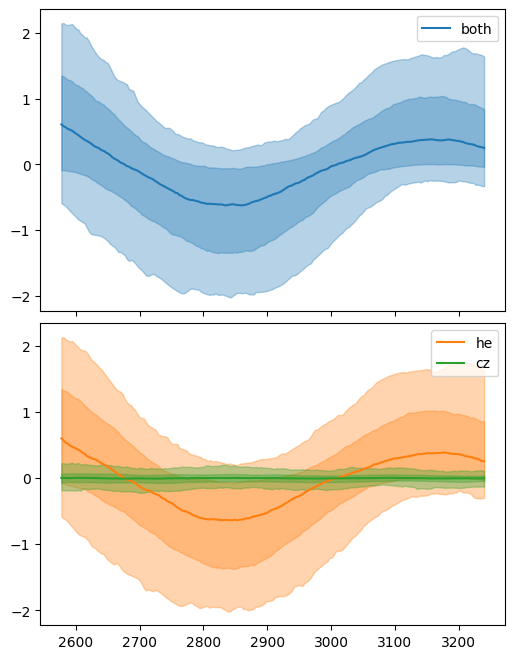

In [93]:
intervals = [(.16, .84), (.025, .975)]

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.04})
ax0 = model.plot_glitch(samples, intervals=intervals, ax=axes[0])

ax0.legend()

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(samples, kind=kind, intervals=intervals, color=f"C{i+1}", ax=ax1)
ax1.legend();

In [94]:
# be careful, this is slow with large numbers of samples
nu_mean, _ = jax.vmap(model.predict, in_axes=(0, None))(samples, n)
dnu = jax.vmap(model.glitch, in_axes=(0, 0))(samples, nu_mean)

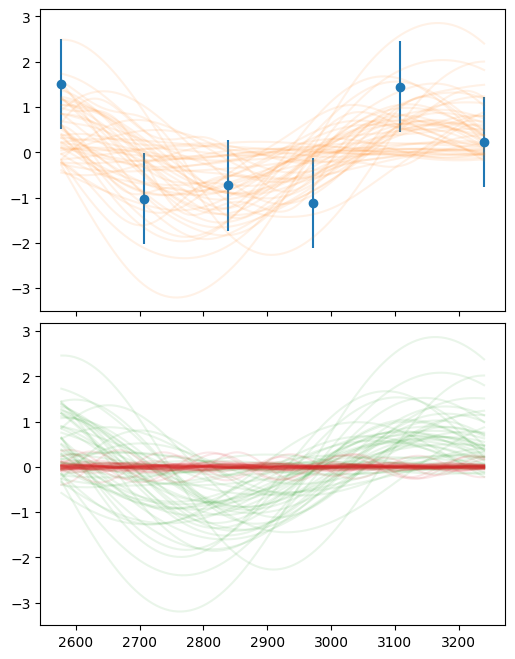

In [95]:
draws = 50
alpha = 0.1

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.04})

res = (model.nu - nu_mean)
ax0 = axes[0]
ax0.errorbar(model.nu, res.mean(axis=0) + dnu.mean(axis=0), yerr=model.nu_err, fmt="o")

ax0 = model.plot_glitch(samples, draws=draws, alpha=alpha, ax=axes[0])

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(samples, kind=kind, draws=draws, alpha=alpha, color=f"C{i+2}", ax=ax1)

In [96]:
med = jax.tree_map(np.median, samples)
low = jax.tree_map(lambda x: np.quantile(x, .16), samples)
upp = jax.tree_map(lambda x: np.quantile(x, .84), samples)

In [97]:
def to_sec(log_tau):
    return 1e6*np.exp(log_tau)

Text(0, 0.5, 'density gradient')

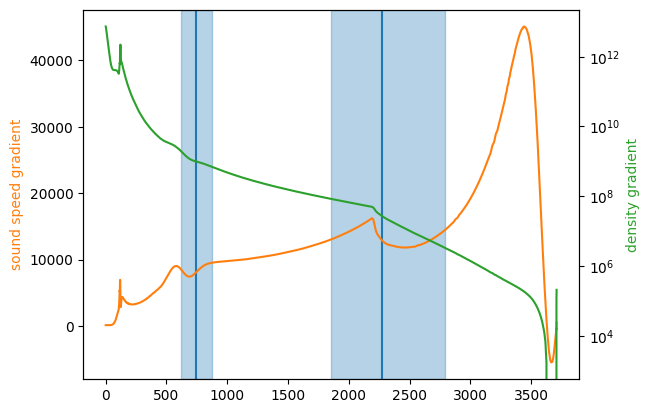

In [98]:
fig, ax = plt.subplots()


for g in ["he", "cz"]:
    ax.axvline(to_sec(med[f"log_tau_{g}"]), color="C0")
    ax.axvspan(to_sec(low[f"log_tau_{g}"]), to_sec(upp[f"log_tau_{g}"]), 
               color="C0", alpha=0.33)

ax.plot(data.tau, differentiate(data.cs, data.tau), color="C1")
ax.set_ylabel("sound speed gradient", color="C1")

ax = ax.twinx()

ax.plot(data.tau, differentiate(data.cs, data.rho), color="C2")
ax.set_yscale("log")
ax.set_ylabel("density gradient", color="C2")

In [99]:
gamma_he = 1e6*jnp.exp(samples["log_alpha_he"])
delta_he = 1e6*jnp.exp(0.5*samples["log_beta_he"])*jnp.sqrt(2)/4/np.pi  # width
tau_he = 1e6*jnp.exp(samples["log_tau_he"])  # location

In [100]:
from jax.scipy.stats import norm

In [101]:
dgamma_gamma = - gamma_he[:, None] * jax.vmap(norm.pdf, in_axes=(None, 0, 0))(data.tau.values, tau_he, delta_he)

In [102]:
dg_med = np.median(dgamma_gamma, axis=0)
dg_low, dg_upp = np.quantile(dgamma_gamma, [.16, .84], axis=0)

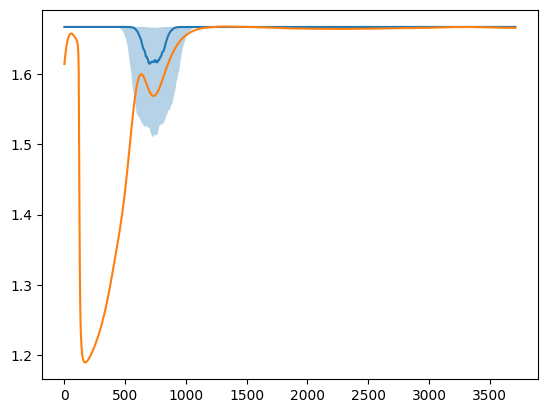

In [103]:
offset = 5/3
plt.plot(data.tau, offset+data.Gamma_1*dg_med)
plt.fill_between(data.tau, offset+data.Gamma_1*dg_low, offset+data.Gamma_1*dg_upp, alpha=0.33)
plt.plot(data.tau, data.Gamma_1)